In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import cv2
import random
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [157]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])

class FrameInterpolationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for subdir in sorted(os.listdir(root_dir))[:500]:
            subdir_path = os.path.join(root_dir, subdir)

            frame_path1 = os.path.join(subdir_path, "frame1.jpg")
            frame_path2 = os.path.join(subdir_path, "frame2.jpg")
            frame_path3 = os.path.join(subdir_path, "frame3.jpg")

            frame1 = cv2.cvtColor(cv2.imread(frame_path1), cv2.COLOR_BGR2RGB)
            frame2 = cv2.cvtColor(cv2.imread(frame_path2), cv2.COLOR_BGR2RGB)
            frame3 = cv2.cvtColor(cv2.imread(frame_path3), cv2.COLOR_BGR2RGB)

            self.samples.append((frame1, frame2, frame3))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame1, frame2, frame3 = self.samples[idx]

        if self.transform:
            frame1 = self.transform(frame1)
            frame2 = self.transform(frame2)
            frame3 = self.transform(frame3)

        x = (frame1, frame3)
        y = frame2
        return x, y

In [158]:
images_train = FrameInterpolationDataset("./atd_12k/datasets/train_128px", transform=transform)

In [159]:
trainloader = DataLoader(images_train, batch_size=2, shuffle=True, num_workers=4)

In [149]:
def denormalize(img: torch.Tensor) -> np.ndarray:
    denorm = transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2))
    img = denorm(img).permute(1, 2, 0).cpu().numpy()
    # img = (img * 255).astype(np.uint8)
    return img

def show(img, denorm=False):
    img = img.cpu()
    if denorm:
        img = denormalize(img)
        
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_3_frames(x, y):
    _, axes = plt.subplots(1, 3, figsize=(10, 3))

    img = denormalize(x[0])
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img)

    img = denormalize(y)
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1].imshow(img)

    img = denormalize(x[1])
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[2].imshow(img)

    plt.show()

In [160]:
x, y = random.choice(images_train)

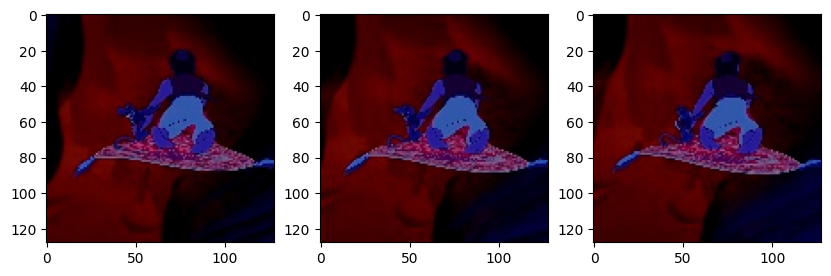

In [161]:
show_3_frames(x, y)

Wykorzystany memflow do generowania optical flow


github.com/DQiaole/MemFlow

In [9]:
from my_evaluate import generates_flow

please consider installing flash attention for faster inference


/home/dominik/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


no flash attention installed


/home/dominik/.local/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


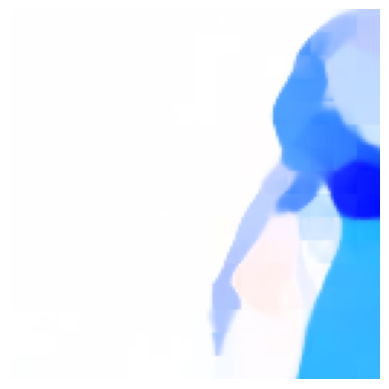

In [10]:
a = generates_flow(x[1], x[0])

show(a)

In [252]:
def warp(img, flow):
    B, _, H, W = img.size()
    grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    grid = torch.stack((grid_x, grid_y), 2).float().to(img.device)  # H x W x 2
    grid = grid.unsqueeze(0).repeat(B, 1, 1, 1)  # B x H x W x 2
    flow = flow.permute(0, 2, 3, 1)
    new_grid = grid + flow
    new_grid[..., 0] = 2.0 * new_grid[..., 0] / (W - 1) - 1.0
    new_grid[..., 1] = 2.0 * new_grid[..., 1] / (H - 1) - 1.0
    return F.grid_sample(img, new_grid, align_corners=True)


class SynthesisNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)


class AnimeInterp(nn.Module):
    def __init__(self):
        super().__init__()
        self.synth_net = SynthesisNet()

    def forward(self, I0, I1, t=0.5):
        flows_f0_1 = []
        flows_f1_0 = []
        for i in range(I0.size(0)):
            i0 = I0.cpu()
            i1 = I1.cpu()
            flow_01 = generates_flow(i0[i], i1[i])[:, :, :2]
            flow_10 = generates_flow(i1[i], i0[i])[:, :, :2]
            flows_f0_1.append(torch.tensor(flow_01).float())
            flows_f1_0.append(torch.tensor(flow_10).float())
        
        f0_1 = torch.stack(flows_f0_1).permute(0, 3, 1, 2).to(device)
        f1_0 = torch.stack(flows_f1_0).permute(0, 3, 1, 2).to(device)

        # Przesunięcia do t
        flow_t0 = -t * f0_1
        flow_t1 = (1 - t) * f1_0

        # Warpowanie
        I0_warp = warp(I0, flow_t0)
        I1_warp = warp(I1, flow_t1)

        # Synteza końcowego obrazu
        x = torch.cat([I0_warp, I1_warp], dim=1)
        It_pred = self.synth_net(x)

        return It_pred

In [253]:
class FrameInterpolationModel(nn.Module):
    def __init__(self):
        super(FrameInterpolationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, frame1, frame3, t=None):
        x = torch.cat([frame1, frame3], dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
import torch.optim as optim

# model = AnimeInterp().to(device)  # To tak średnio
model = FrameInterpolationModel().to(device)  # Losowy autoencoder działa
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

In [255]:
epochs = 20

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for x, y in tqdm(trainloader):
        frame0, frame1 = x[0].to(device), x[1].to(device)
        frame_gt = y.to(device)

        pred = model(frame0, frame1, t=0.5)

        loss = criterion(pred, frame_gt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"[{epoch+1}/{epochs}] Loss: {running_loss/len(trainloader):.6f}")


100%|██████████| 250/250 [00:13<00:00, 18.54it/s]


[1/20] Loss: 0.192672


100%|██████████| 250/250 [00:13<00:00, 18.70it/s]


[2/20] Loss: 0.148689


100%|██████████| 250/250 [00:13<00:00, 19.00it/s]


[3/20] Loss: 0.142650


100%|██████████| 250/250 [00:13<00:00, 18.74it/s]


[4/20] Loss: 0.121497


100%|██████████| 250/250 [00:13<00:00, 18.81it/s]


[5/20] Loss: 0.115486


100%|██████████| 250/250 [00:13<00:00, 18.60it/s]


[6/20] Loss: 0.108695


100%|██████████| 250/250 [00:13<00:00, 18.88it/s]


[7/20] Loss: 0.094377


100%|██████████| 250/250 [00:13<00:00, 18.85it/s]


[8/20] Loss: 0.094210


100%|██████████| 250/250 [00:13<00:00, 18.57it/s]


[9/20] Loss: 0.090360


100%|██████████| 250/250 [00:13<00:00, 18.93it/s]


[10/20] Loss: 0.089162


100%|██████████| 250/250 [00:13<00:00, 18.59it/s]


[11/20] Loss: 0.093571


100%|██████████| 250/250 [00:13<00:00, 18.77it/s]


[12/20] Loss: 0.087999


100%|██████████| 250/250 [00:13<00:00, 18.79it/s]


[13/20] Loss: 0.083671


100%|██████████| 250/250 [00:13<00:00, 18.72it/s]


[14/20] Loss: 0.079177


100%|██████████| 250/250 [00:13<00:00, 18.84it/s]


[15/20] Loss: 0.083982


100%|██████████| 250/250 [00:13<00:00, 18.67it/s]


[16/20] Loss: 0.081422


100%|██████████| 250/250 [00:13<00:00, 18.81it/s]


[17/20] Loss: 0.078086


100%|██████████| 250/250 [00:13<00:00, 18.74it/s]


[18/20] Loss: 0.078996


100%|██████████| 250/250 [00:13<00:00, 18.80it/s]


[19/20] Loss: 0.077593


100%|██████████| 250/250 [00:13<00:00, 18.83it/s]

[20/20] Loss: 0.077826


In [256]:
def evaluate_on_two_images(model, img1, img2, device="cpu"):
    model.eval()
    with torch.no_grad():
        I0 = torch.Tensor(img1).unsqueeze(0)
        I1 = torch.Tensor(img2).unsqueeze(0)

        pred_mid = model(I0.to(device), I1.to(device))

        return pred_mid.squeeze(0)


def psnr(pred, target, max_val=1.0):
    mse = F.mse_loss(pred, target)
    psnr = 10 * torch.log10(max_val ** 2 / mse)
    return psnr

In [257]:
x, y = random.choice(images_train)

img_tensor = evaluate_on_two_images(model, x[0], x[1], device=device)



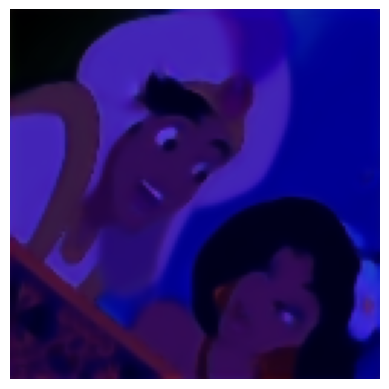

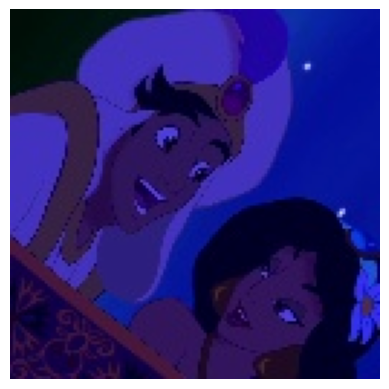

In [258]:
show(img_tensor, True)
show(y.squeeze(), True)

## PSNR

In [266]:
psnrs = []

model.eval()
for x, y in images_train:
    img_tensor = evaluate_on_two_images(model, x[0], x[1], device=device).cpu()
    psnrs.append(psnr(img_tensor, y))

psnrs = np.array(psnrs)

print(np.mean(psnrs), np.std(psnrs))


17.433891 3.0082426
